# Image Captioning with InceptionV3 and LSTM

This notebook demonstrates how to build an image captioning model using a combination of InceptionV3 for image feature extraction and an LSTM network for caption generation.

## 1. Data Loading and Preprocessing

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter


2025-07-01 16:59:50.087359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751389190.297618      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751389190.359663      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [ ]:
images_directory = f'{path}/Images/'
captions_path = f'{path}/captions.txt'
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]


['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [ ]:
import regex as re

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]


['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [ ]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)


(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

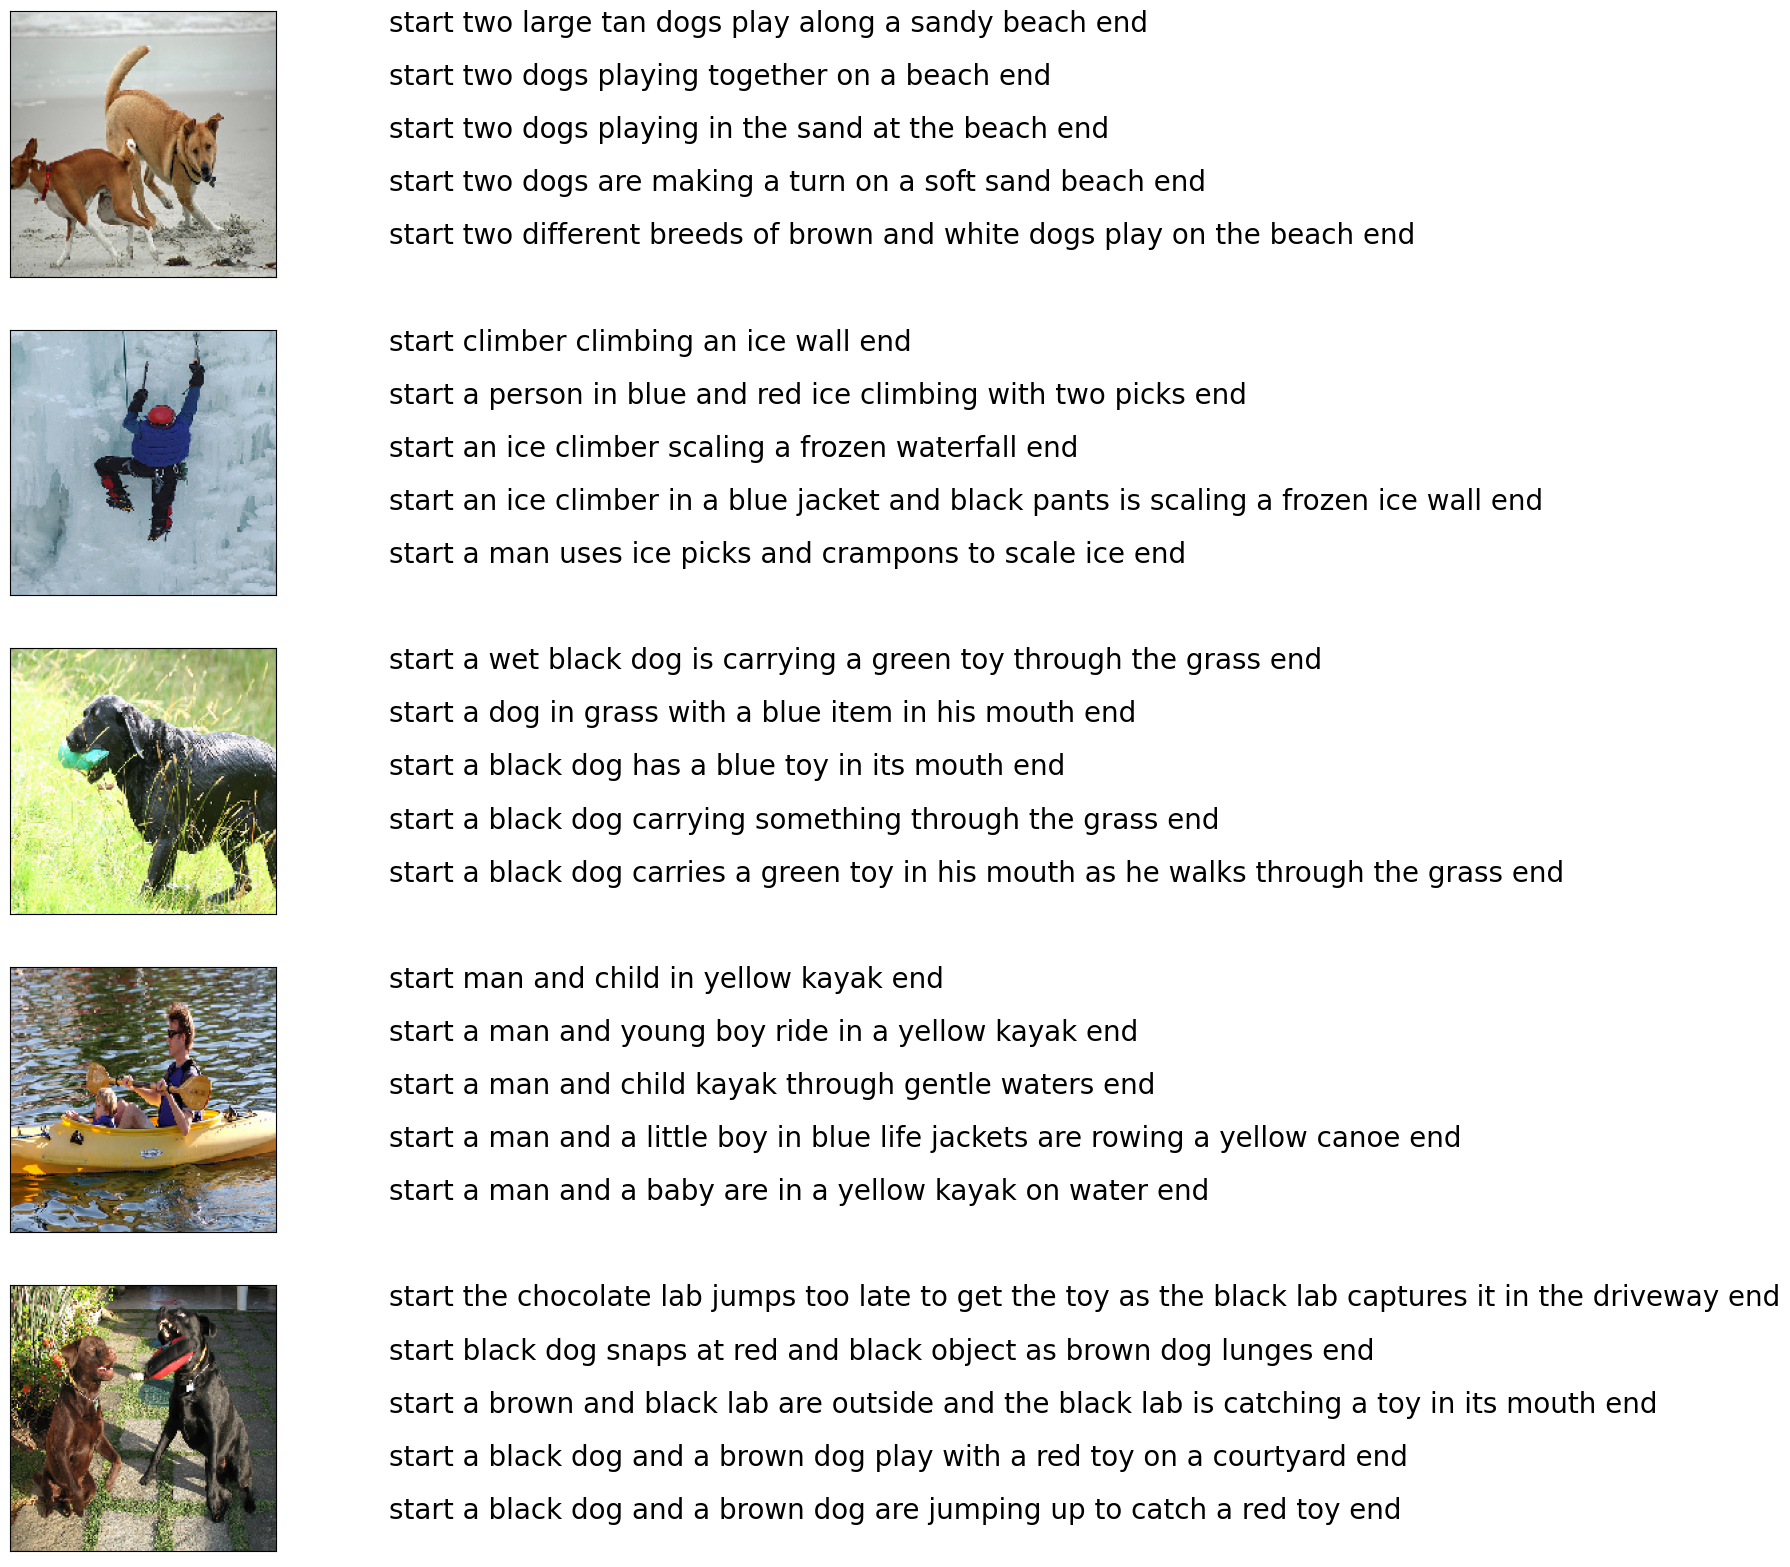

In [ ]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)


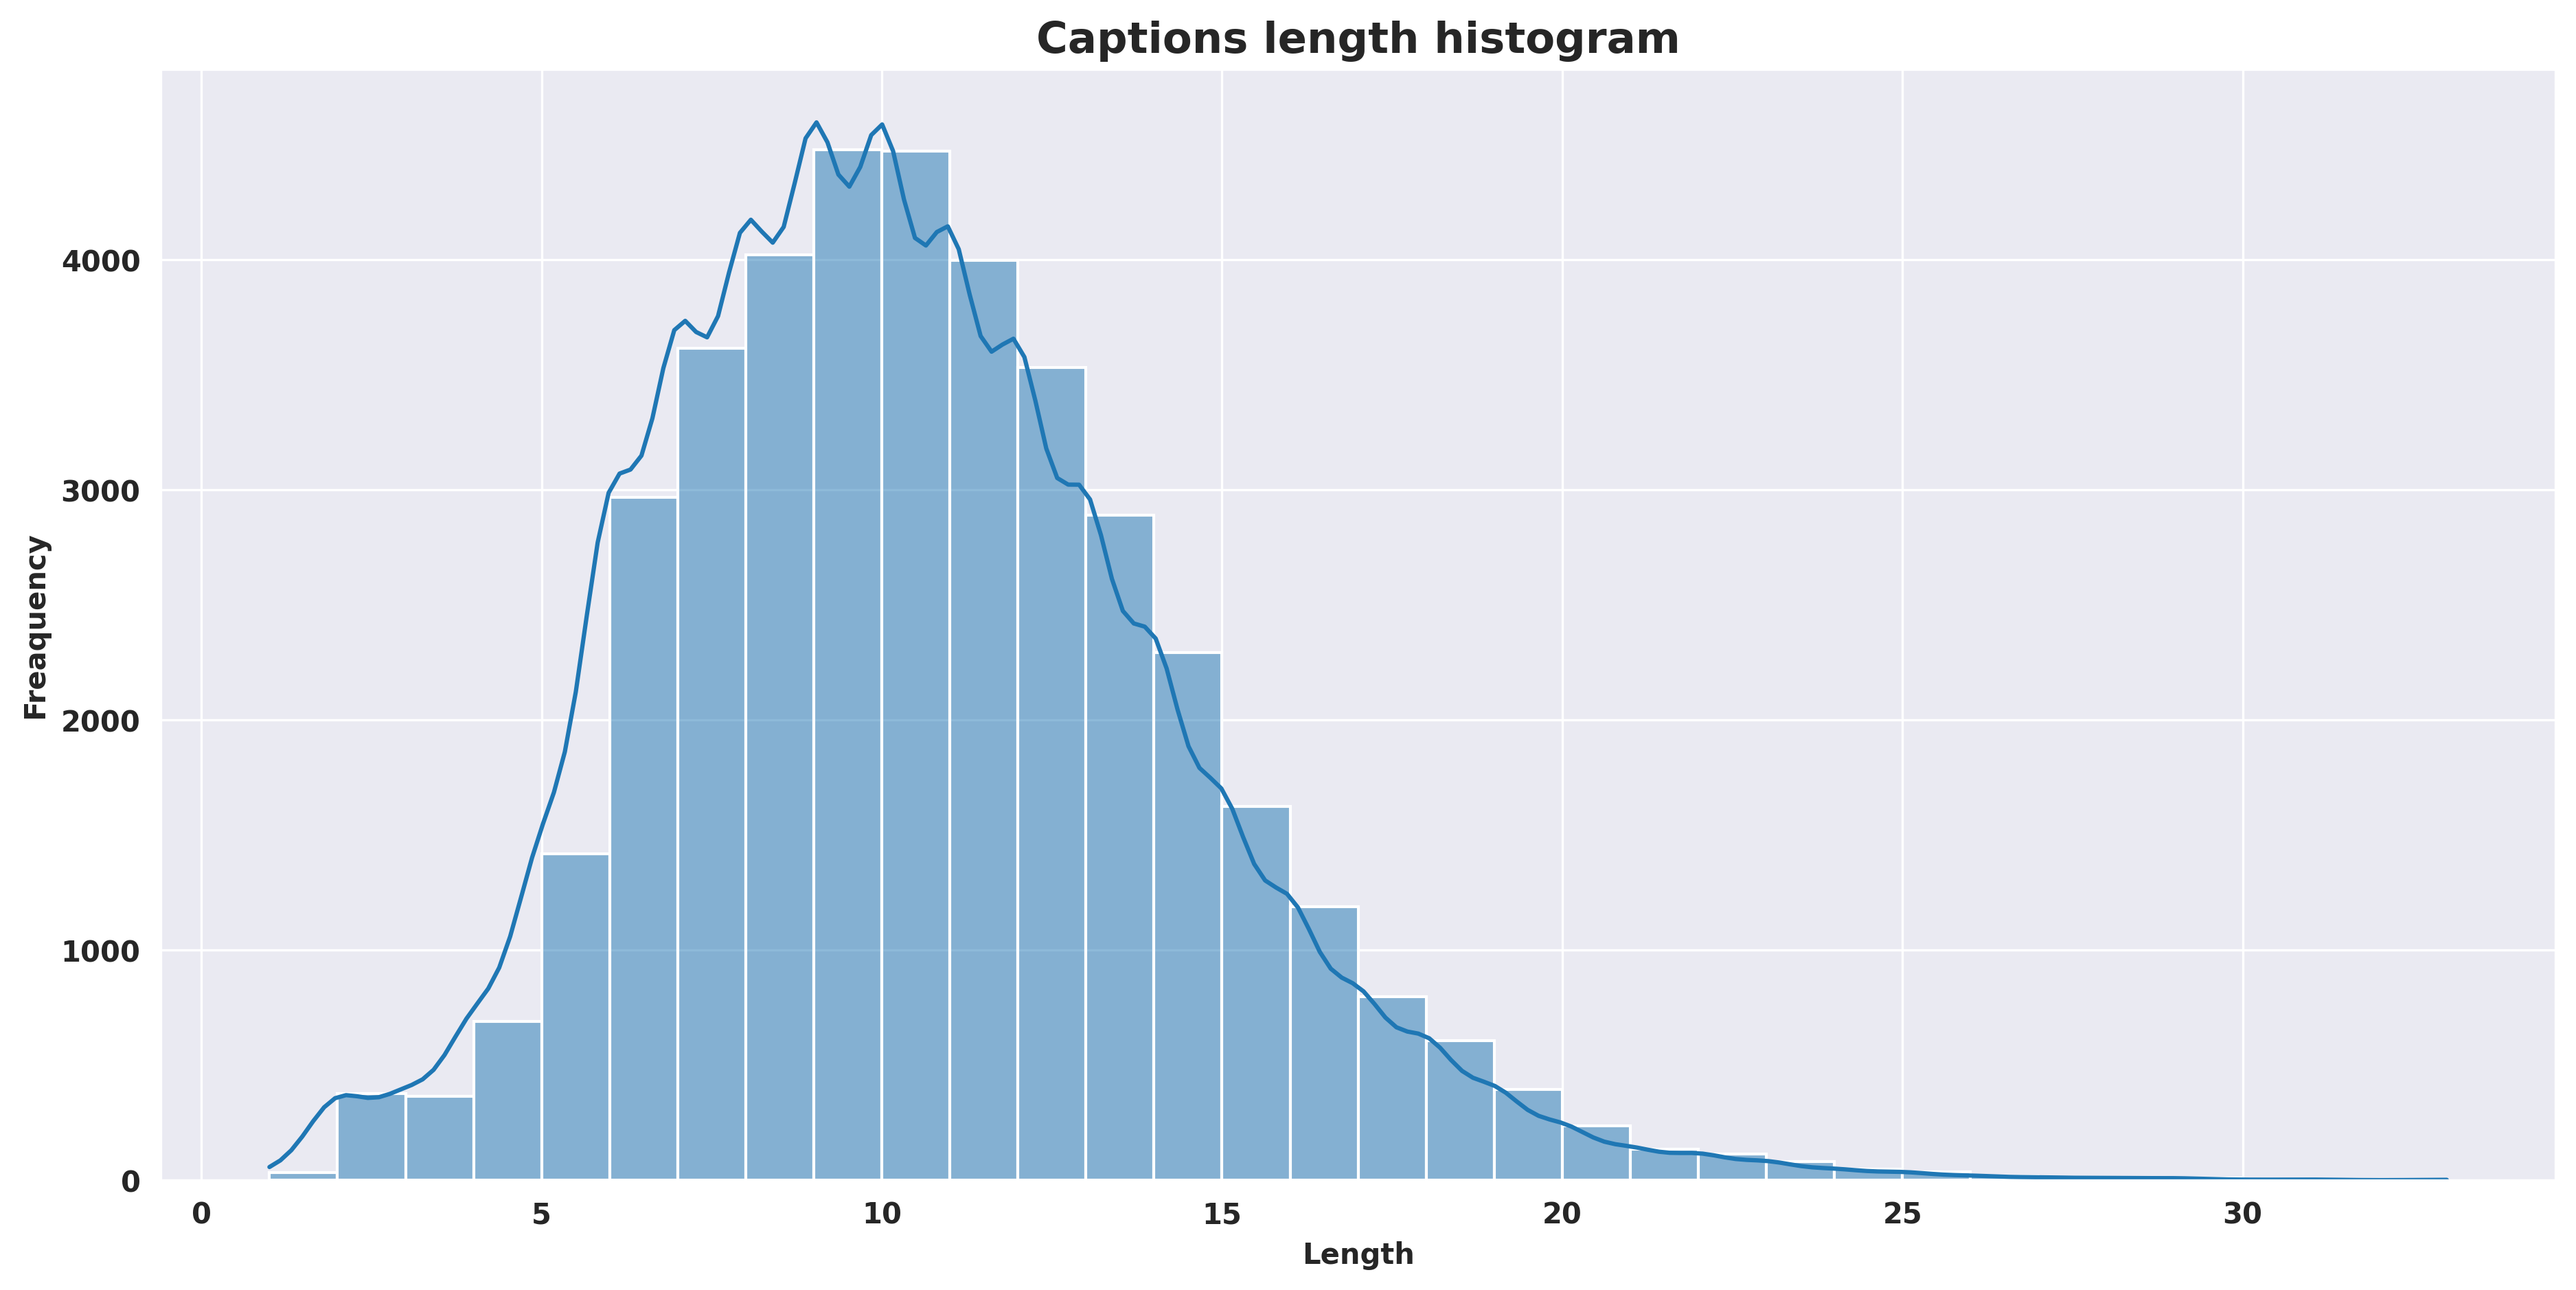

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)


In [ ]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size


8586

In [ ]:
#save the tokenizer for later inference
import pickle

with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

#load
with open('/kaggle/working/tokenizer.pkl', 'rb') as f:
    tok_test = pickle.load(f)

tok_test

In [ ]:
#also save to json for portability
# Save tokenizer to JSON
tokenizer_json = tokenizer.to_json()
with open('/kaggle/working/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Load tokenizer from JSON
with open('/kaggle/working/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()

toke = tokenizer_from_json(tokenizer_json)
toke

## 2. Image Feature Extraction

In [ ]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5


('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)


In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1751389217.590679     102 service.cc:148] XLA service 0x7fe2f80038d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751389217.591576     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751389217.591598     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751389218.615526     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751389223.572203     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
max_caption_length = 34
max_caption_length

34

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math  # Import math for exp

# Assuming vocab_size is defined
# vocab_size = len(tokenizer.word_index) + 1

def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]  # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0] # Added padding='post'
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)

# Define parameters
max_caption_length = max(len(caption.split()) for caption in train_captions) + 1
cnn_output_dim = 2048  # From inception_v3_model.output_shape[1]
batch_size_train = 270
batch_size_val = 150
vocab_size = len(tokenizer.word_index) + 1  # Ensure vocab_size is defined

In [ ]:
max_caption_length

37

## 3. Model Building and Training

In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequence_Input            │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │      2,198,016 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 37)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ batch_normalization_9… │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 8586)           │      2,206,602 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

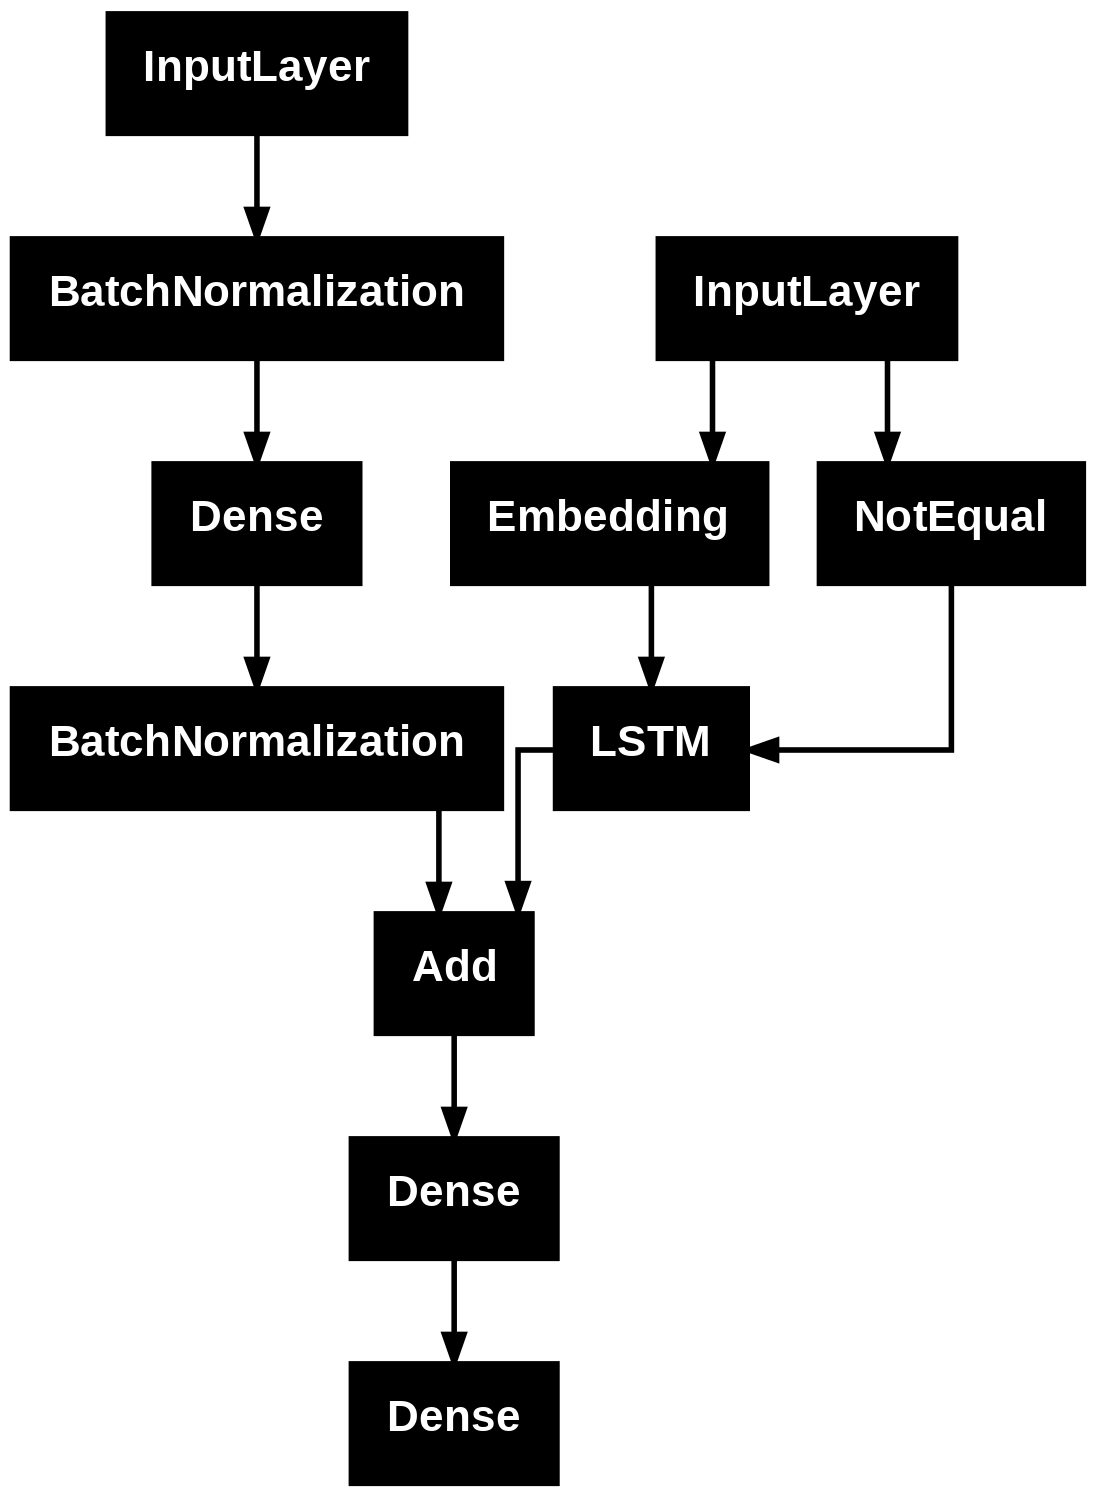

In [ ]:
plot_model(caption_model)


In [ ]:
# Define output_signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),  # X_images
        tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32),  # X_captions
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y
)

# Create TensorFlow datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val),
    output_signature=output_signature
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * math.exp(-0.6)  # Use math.exp instead of tf.math.exp

lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 59s 416ms/step - loss: 5.2068 - val_loss: 3.7348 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 53s 416ms/step - loss: 3.3704 - val_loss: 3.3596 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - loss: 2.9723 - val_loss: 3.2542 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 55s 433ms/step - loss: 2.7517 - val_loss: 3.2249 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 55s 432ms/step - loss: 2.6226 - val_loss: 3.2236 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 52s 410ms/step - loss: 2.5422 - val_loss: 3.2239 - learning_rate: 2.7324e-04
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 52s 411ms/step - loss: 2.4956 - val_loss: 3.2279 - learning_rate: 1.4996e-04
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 51s 406ms/step - loss: 2.4639 - val_loss: 3.2313 - learning_rate: 8.2297e-05


In [ ]:
# Save the entire model to a HDF5 file
caption_model.save('caption_model.h5')
caption_model.save('kaggle/working/caption_model.h5')


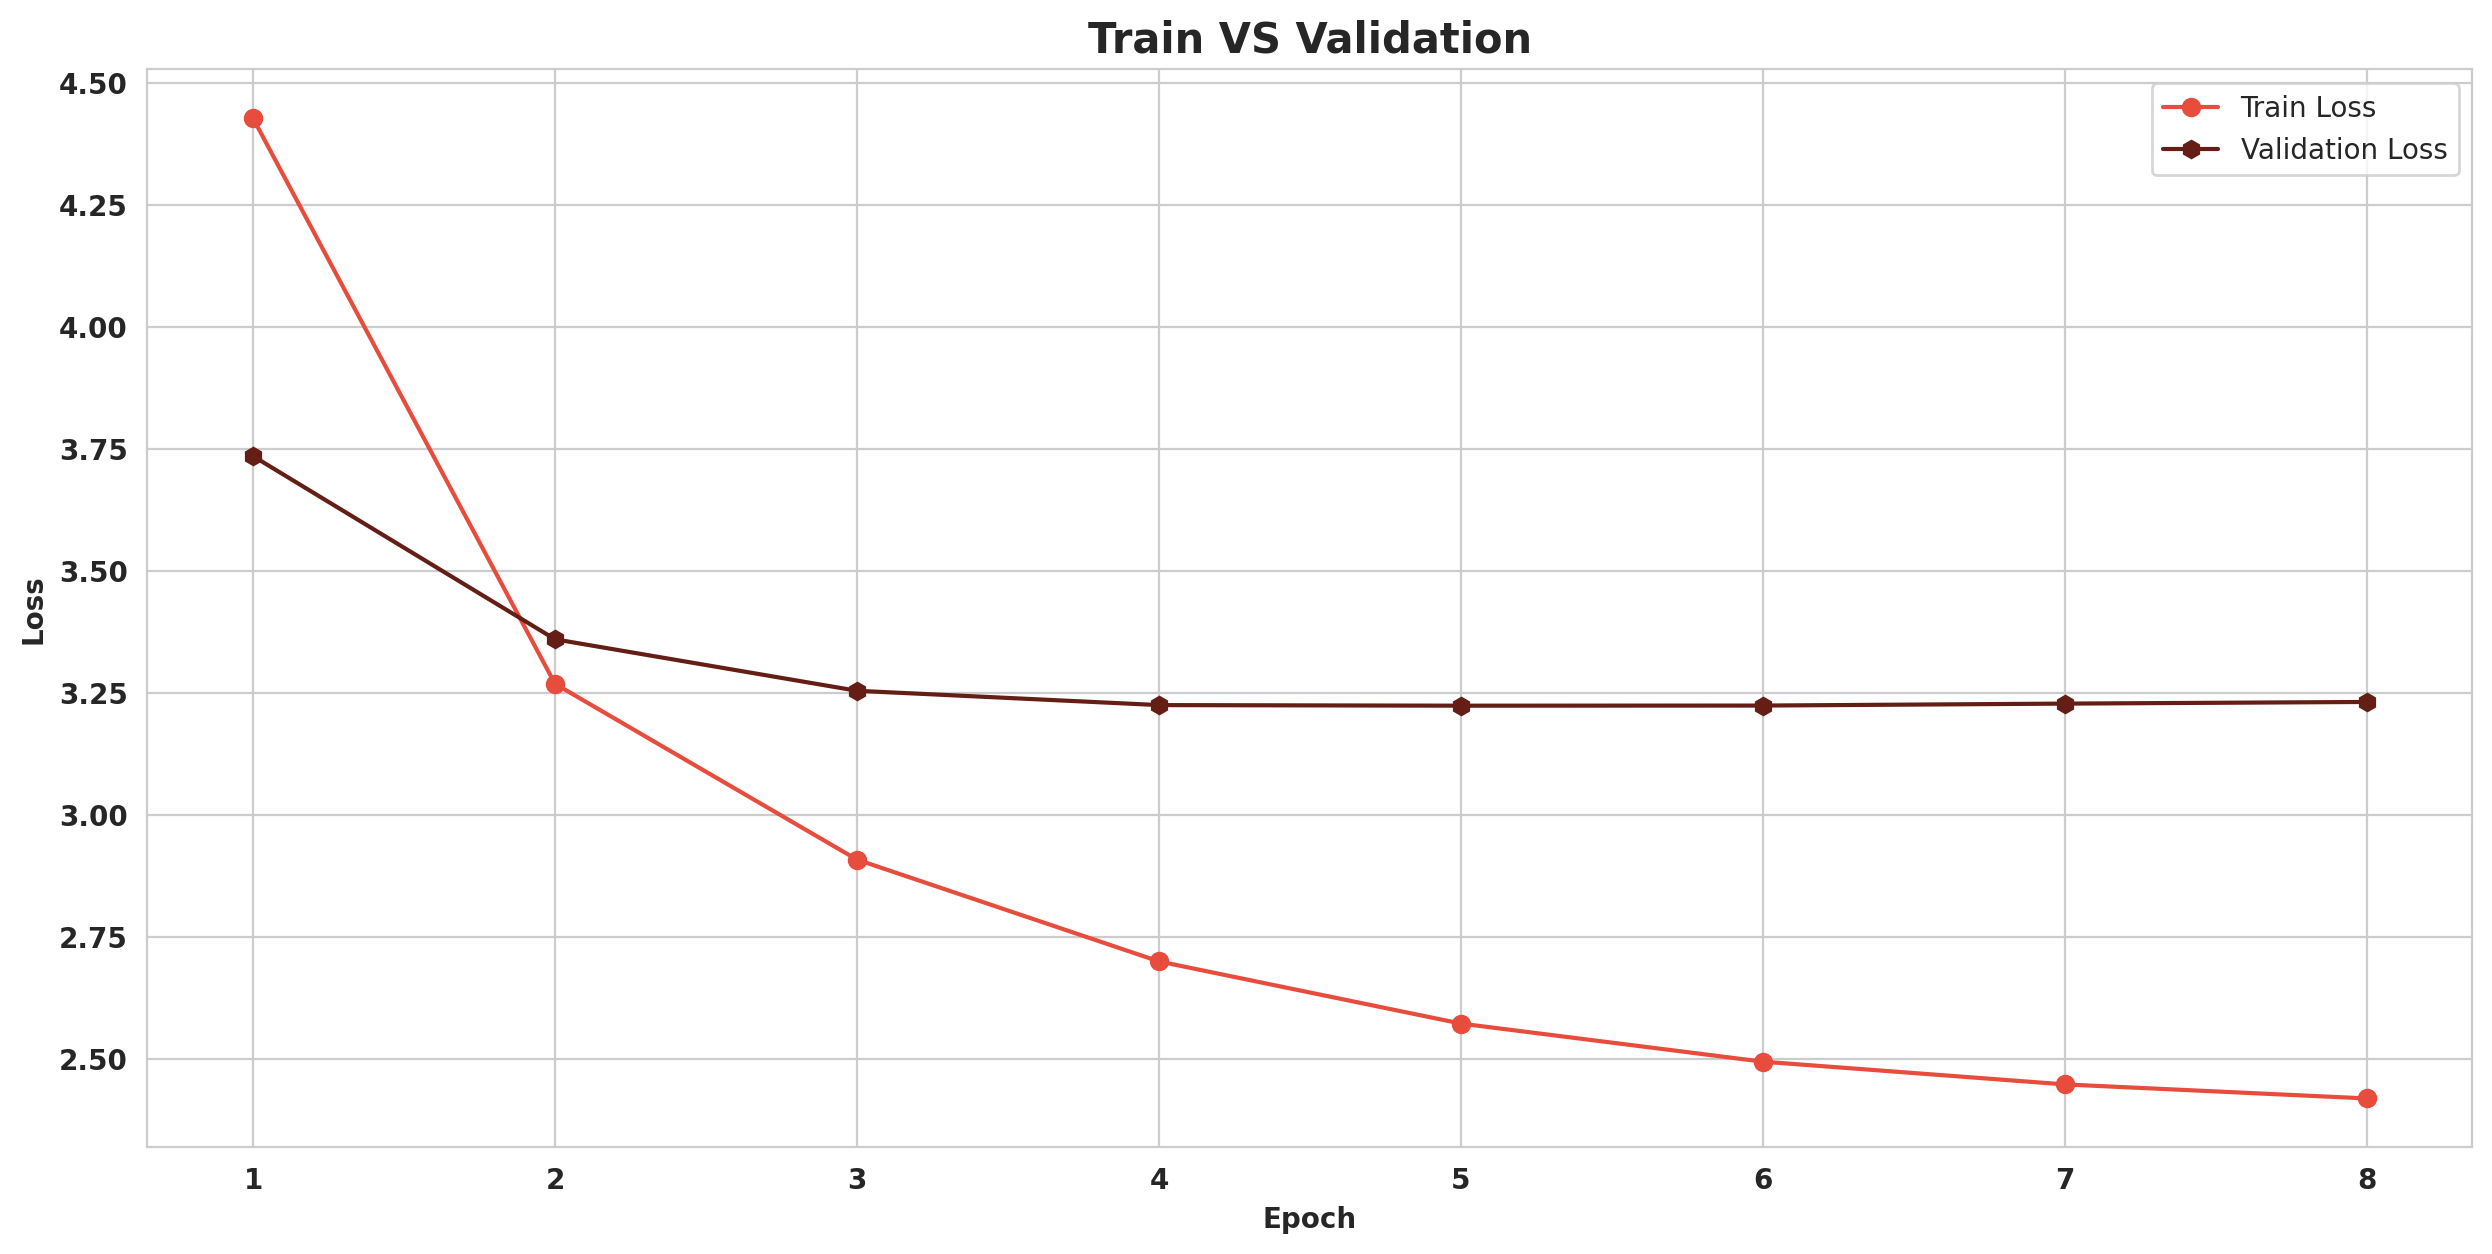

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()


## 4. Model Evaluation and Prediction

In [ ]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post').reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [ ]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length, padding='post').reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]


In [ ]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()


  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
test_actual_captions = {}

pbar = tqdm_notebook(total=len(test_captions), position=0, leave=True, colour='green')  # Updated for test_captions
for caption in test_captions:
    image_id, caption_text = caption.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption_text)  # Appending caption
    pbar.update(1)

pbar.close()

  0%|          | 0/610 [00:00<?, ?it/s]

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

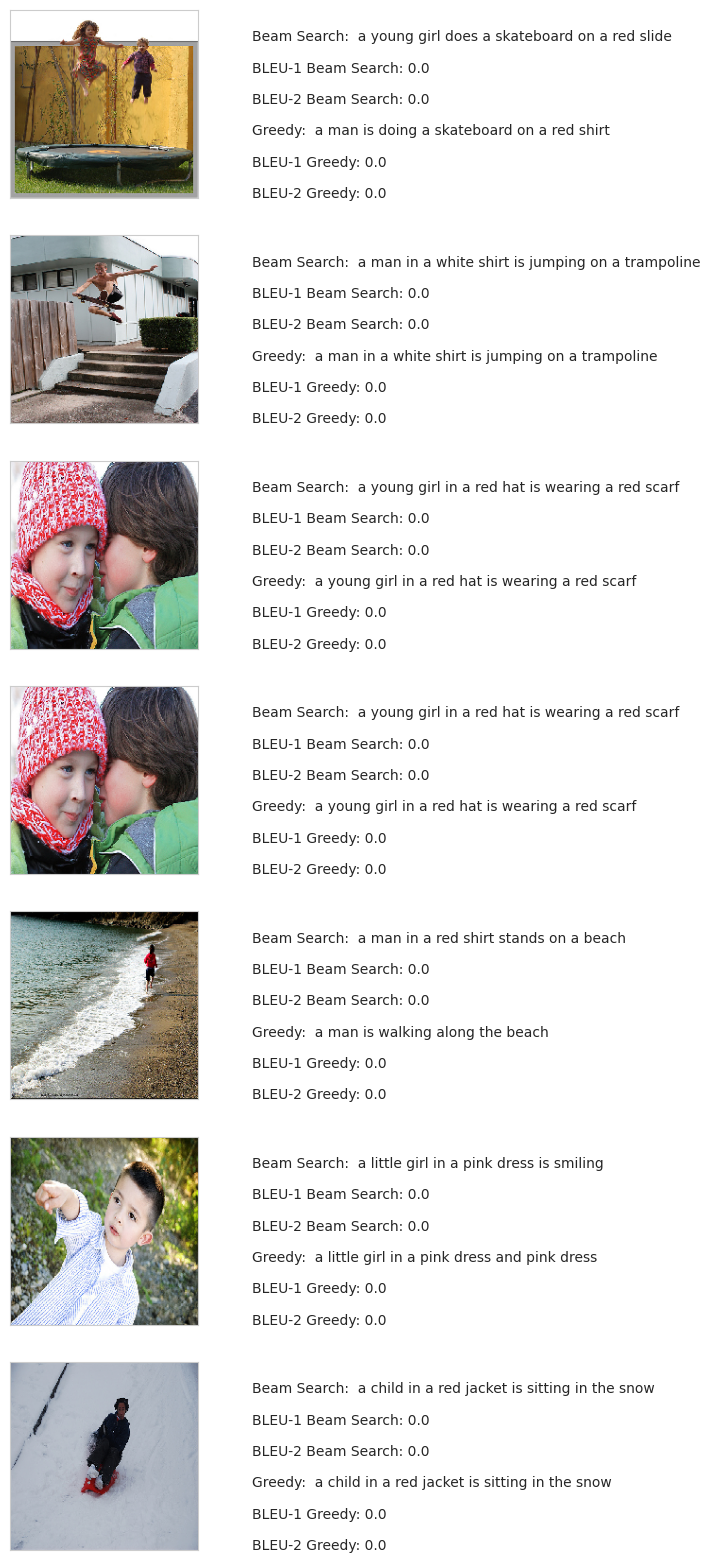

In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap]
        actual_cap = [x.replace(" end", "") for x in actual_cap]

        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)


In [ ]:
!wget https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Fphotos%2Fgroup-of-teenage-boys-and-girls-dancing-at-nightclub&psig=AOvVaw0zusEdL6oHWKbtwZWAIl42&ust=1745780341236000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCNC8jN2w9owDFQAAAAAdAAAAABAT

In [ ]:
!ls

caption_model.h5  model.png


In [ ]:

# 2. Preprocess the image
image_path = f'{path}/Images/1012212859_01547e3f17.jpg'
processed_image = preprocess_image(image_path)

# 3. Extract image features
image_features = inception_v3_model.predict(processed_image, verbose=0)
image_features = image_features.flatten()

# 4. Generate captions
greedy_caption = greedy_generator(image_features)
print("Greedy Caption:", greedy_caption)

beam_search_caption = beam_search_generator(image_features)
print("Beam Search Caption:", beam_search_caption)

Greedy Caption:  a white dog is playing with a white ball in the water
Beam Search Caption: a white dog is playing with a white ball in its mouth


In [ ]:
import requests

image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpmMGdUkQ16NxGZMuMRm2Srfjsj2TYh6MulA&s"
image_name = "fight.jpg"  # Choose a filename for the image

response = requests.get(image_url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses

with open(image_name, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"Image downloaded as {image_name}")

Image downloaded as fight.jpg


In [ ]:

# 2. Preprocess the image
image_path = 'fight.jpg'
processed_image = preprocess_image(image_path)

# 3. Extract image features
image_features = inception_v3_model.predict(processed_image, verbose=0)
image_features = image_features.flatten()

# 4. Generate captions
greedy_caption = greedy_generator(image_features)
print("Greedy Caption:", greedy_caption)

beam_search_caption = beam_search_generator(image_features)
print("Beam Search Caption:", beam_search_caption)

Greedy Caption:  a basketball player in a white uniform is playing a game
Beam Search Caption: a basketball player in a white uniform is playing a basketball


In [ ]:
def predict_image_caption(image_path):
    # Step 2: Preprocess the image
    processed_image = preprocess_image(image_path)

    # Step 3: Extract image features using the InceptionV3 model
    image_features = inception_v3_model.predict(processed_image, verbose=0)
    image_features = image_features.flatten()

    # Step 4: Generate captions using both methods
    greedy_caption = greedy_generator(image_features)
    beam_search_caption = beam_search_generator(image_features)

    # Print captions
    print("Greedy Caption:", greedy_caption)
    print("Beam Search Caption:", beam_search_caption)

    # Return captions
    return greedy_caption, beam_search_caption


In [ ]:
caption_model = load_model('/kaggle/working/caption_model.h5')

ValueError: Unknown layer: 'NotEqual'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
predict_image_caption('/kaggle/working/fight.jpg')

InvalidArgumentError: Graph execution error:

Detected at node Image_Captioning_1/lstm_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_35/3044426981.py", line 5, in <cell line: 0>

  File "/tmp/ipykernel_35/111999354.py", line 6, in greedy_generator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py", line 402, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node Image_Captioning_1/lstm_1/Assert/Assert}}]] [Op:__inference_one_step_on_data_distributed_450121]

## 5. Gradio Interface (Optional)

In [ ]:

import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import requests

# Load the model
caption_model = load_model('caption_model.h5')

# Load necessary components (assuming they're defined in your original code)
# ... (Load tokenizer, inception_v3_model, etc.) ...
# Replace these placeholders with your actual loading code.
# Example:
# tokenizer = ...  # Load tokenizer
inception_v3_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = tf.keras.models.Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)
max_caption_length = 34 # Replace with your actual value
cnn_output_dim = 2048 #Replace with your actual value
tokenizer = None # Replace with your actual tokenizer

def preprocess_image(image):
    img = load_img(image, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def greedy_generator(image_features):
    # Your greedy_generator function from the original code
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text


def predict(image):
  processed_image = preprocess_image(image)
  image_features = inception_v3_model.predict(processed_image, verbose=0)
  image_features = image_features.flatten()
  caption = greedy_generator(image_features)
  return caption

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="filepath"), # changed to filepath to handle local files correctly.
    outputs="text",
    title="Image Captioning",
    description="Upload an image to generate a caption."
)

iface.launch()


ModuleNotFoundError: No module named 'gradio'

In [ ]:
def preprocess_image(image):
    img = load_img(image, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def greedy_generator(image_features):
    # Your greedy_generator function from the original code
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

def predict(image):
  processed_image = preprocess_image(image)
  image_features = inception_v3_model.predict(processed_image, verbose=0)
  image_features = image_features.flatten()
  caption = greedy_generator(image_features)
  return caption


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
!python --version


Python 3.11.11


In [ ]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length, padding='post').reshape((1,max_caption_length)).astype('float32') # Cast to float32
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post').reshape((1,max_caption_length)).astype('float32') # Cast to float32
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tensorflow.keras.layers import Add # Import the Add layer

# Load the saved model, specifying custom objects
loaded_caption_model = load_model('kaggle/working/caption_model.keras')

# Assume tokenizer, inception_v3_model, max_caption_length, and cnn_output_dim are already defined in the notebook
# If not, you would need to load/define them here.
# Example (replace with your actual loading/definition if needed):
# tokenizer = ...
# inception_v3_model = ...
# max_caption_length = ...
# cnn_output_dim = ...

def predict_caption(image_path):
    """
    Predicts a caption for a given image.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: The generated caption.
    """
    # Preprocess the image
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    # Extract image features using the InceptionV3 model
    image_features = inception_v3_model.predict(img, verbose=0)
    image_features = image_features.flatten()

    # Generate caption using the greedy search method (assuming greedy_generator is defined)
    # If you want to use beam search, call beam_search_generator instead.
    predicted_caption = greedy_generator(image_features)

    return predicted_caption

# Example usage:
# image_path_to_predict = 'path/to/your/image.jpg' # Replace with your image path
# generated_caption = predict_caption(image_path_to_predict)
# print("Predicted Caption:", generated_caption)

In [ ]:
# Save the entire model to a HDF5 file
caption_model.save('kaggle/working/caption_model.keras')

In [ ]:
predict_caption('/kaggle/working/fight.jpg')

' a basketball player in a white uniform is playing a game'